In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.fftpack import fft, ifft, fftfreq

def load_image(file_path):
    image = Image.open(file_path).convert('L')
    return np.array(image, dtype=np.float32)

def radon_transform(image, delta_alpha, n_detectors, spread):
    h, w = image.shape
    angles = np.deg2rad(np.arange(0, 180, delta_alpha))
    s = np.linspace(-spread/2, spread/2, n_detectors)
    sinogram = np.zeros((len(angles), n_detectors))
    
    center_x, center_y = w // 2, h // 2
    
    for i, theta in enumerate(angles):
        cos_t, sin_t = np.cos(theta), np.sin(theta)
        
        for j, s_val in enumerate(s):
            line_sum = 0.0
            for t in np.linspace(-max(h, w)//2, max(h, w)//2, max(h, w)):
                x = int(center_x + s_val * cos_t + t * (-sin_t))
                y = int(center_y + s_val * sin_t + t * cos_t)
                
                if 0 <= x < w and 0 <= y < h:
                    line_sum += image[y, x]
            
            sinogram[i, j] = line_sum
    
    return sinogram

def apply_filter(sinogram):
    num_projections, num_detectors = sinogram.shape
    freqs = fftfreq(num_detectors).reshape(1, -1)
    filter_kernel = np.abs(freqs)  # Filtr Ram-Lak
    
    sinogram_fft = fft(sinogram, axis=1)
    filtered_sinogram = np.real(ifft(sinogram_fft * filter_kernel, axis=1))
    
    return filtered_sinogram

def apply_filter1(sinogram):
    n = sinogram.shape[1]
    ramp = np.abs(fftfreq(n))
    
    # Okno Shepp-Logan
    window = np.sinc(fftfreq(n)*0.5)
    filt = ramp * window

    sinogram_fft = fft(sinogram, axis=1)
    return np.real(ifft(sinogram_fft * filt, axis=1))

def inverse_radon_transform(sinogram, delta_alpha):
    h, w = sinogram.shape[1], sinogram.shape[1]
    reconstructed = np.zeros((h, w))
    angles = np.deg2rad(np.arange(0, 180, delta_alpha))
    center = w // 2
    
    for i, theta in enumerate(angles):
        cos_t, sin_t = np.cos(theta), np.sin(theta)
        for x in range(w):
            for y in range(h):
                s = (x - center) * cos_t + (y - center) * sin_t
                s_idx = int(s + sinogram.shape[1] // 2)
                
                if 0 <= s_idx < sinogram.shape[1]:
                    reconstructed[y, x] += sinogram[i, s_idx]
    
    return reconstructed / len(angles)

def process_image(file_path, delta_alpha, n_detectors, spread):

    image_array = load_image(file_path)
    sinogram = radon_transform(image_array, delta_alpha, n_detectors, spread)

    filtered_sinogram = apply_filter(sinogram)
    filtered_sinogram1 = apply_filter1(sinogram)

    reconstructed_image_without_filter = inverse_radon_transform(sinogram, delta_alpha)
    
    reconstructed_image = inverse_radon_transform(filtered_sinogram, delta_alpha)
    reconstructed_image_second = inverse_radon_transform(filtered_sinogram1, delta_alpha)
    
    fig, axs = plt.subplots(2, 4, figsize=(16, 5))

    axs[0,0].imshow(image_array, cmap='gray')
    axs[0,0].set_title("Oryginalny obraz")

    axs[0,1].imshow(sinogram, cmap='gray', aspect='auto')
    axs[0,1].set_title("Sinogram")

    axs[0,2].imshow(filtered_sinogram, cmap='gray', aspect='auto')
    axs[0,2].set_title("Filtrowany sinogram")

    axs[0,3].imshow(filtered_sinogram1, cmap='gray', aspect='auto')
    axs[0,3].set_title("Filtrowany sinogram 1")

    axs[1,0].imshow(reconstructed_image_without_filter, cmap='gray')
    axs[1,0].set_title("Rekonstrukcja bez filtru")

    axs[1,1].imshow(reconstructed_image, cmap='gray')
    axs[1,1].set_title("Rekonstrukcja z filtrem")

    axs[1,2].imshow(reconstructed_image_second, cmap='gray')
    axs[1,2].set_title("Rekonstrukcja z filtrem 1")

    axs[1,3].axis('off')  # ostatnia pusta

    plt.tight_layout()
    plt.show()



Uruchamianie na różnych obrazach

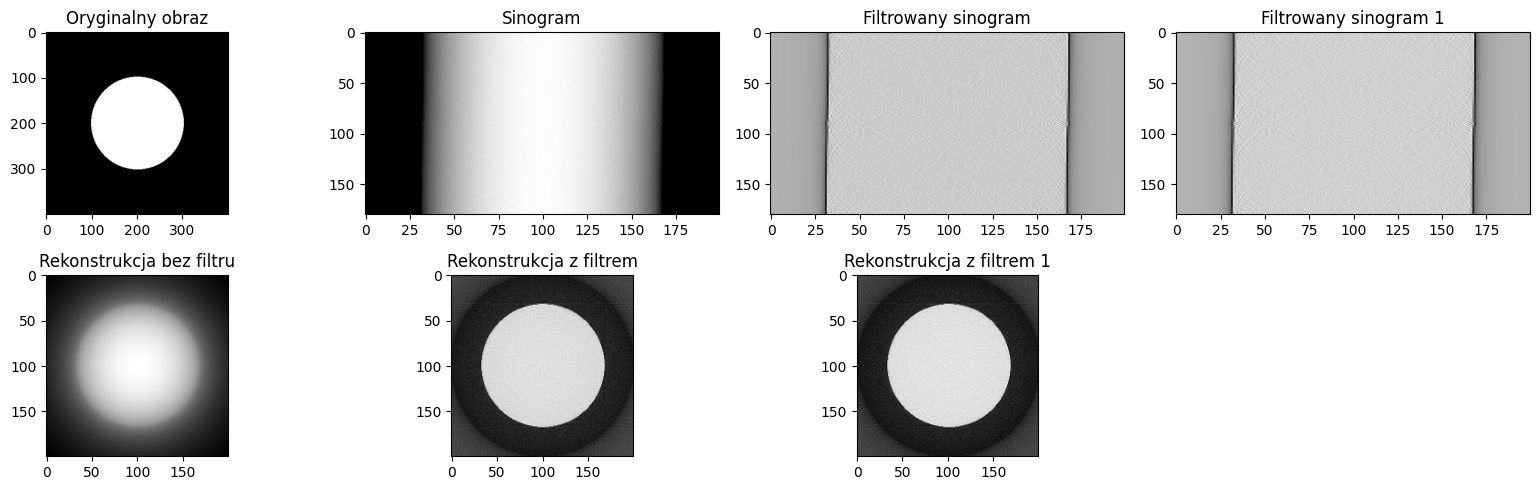

In [27]:
file_path = "tomograf-obrazy/Kolo.jpg"
process_image(file_path, delta_alpha=1, n_detectors=200, spread=300)

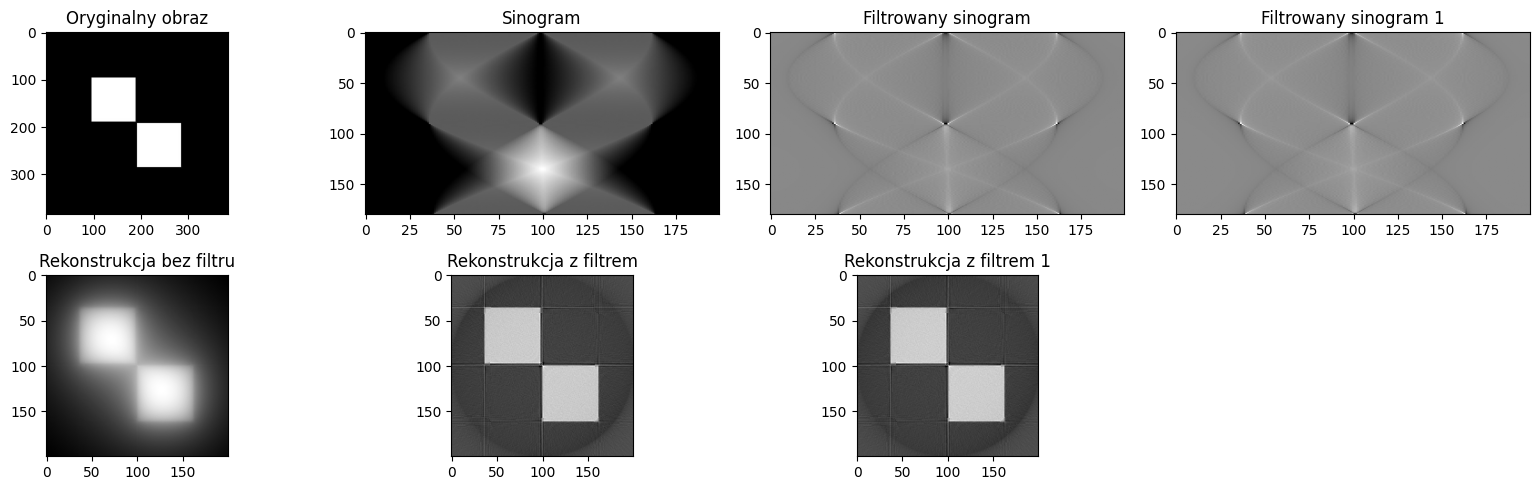

In [28]:
file_path = "tomograf-obrazy/Kwadraty2.jpg"
process_image(file_path, delta_alpha=1.0, n_detectors=200, spread=300)

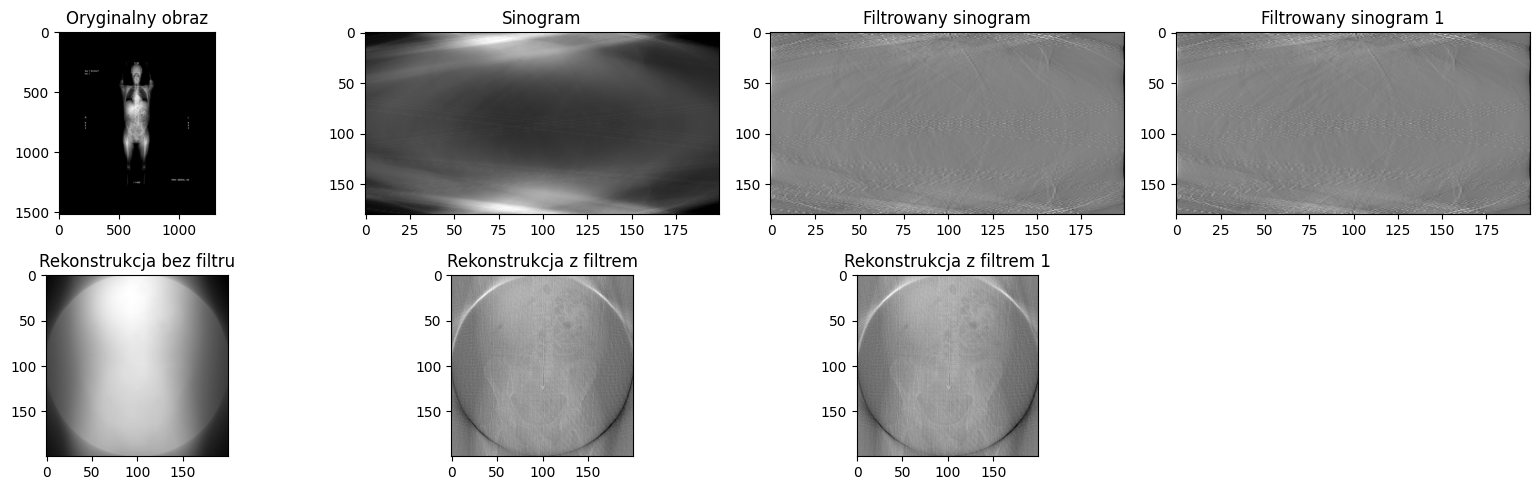

In [29]:
file_path = "tomograf-obrazy/CT_ScoutView-large.jpg"
process_image(file_path, delta_alpha=1.0, n_detectors=200, spread=300)

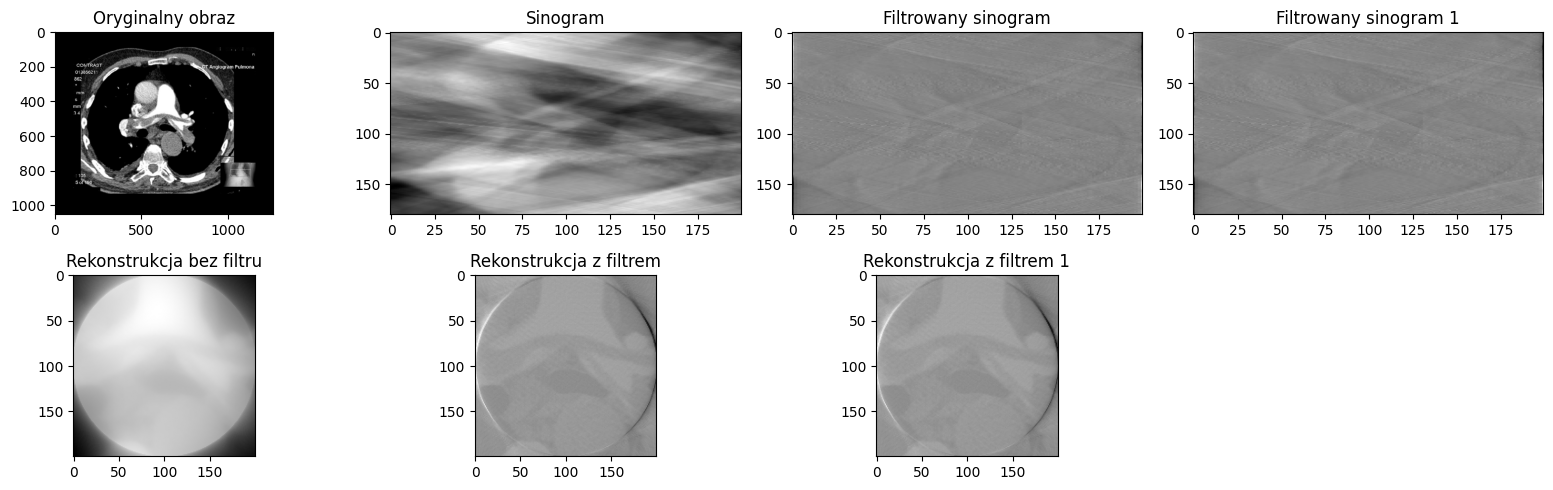

In [30]:
file_path = "tomograf-obrazy/SADDLE_PE-large.jpg"
process_image(file_path, delta_alpha=1.0, n_detectors=200, spread=300)

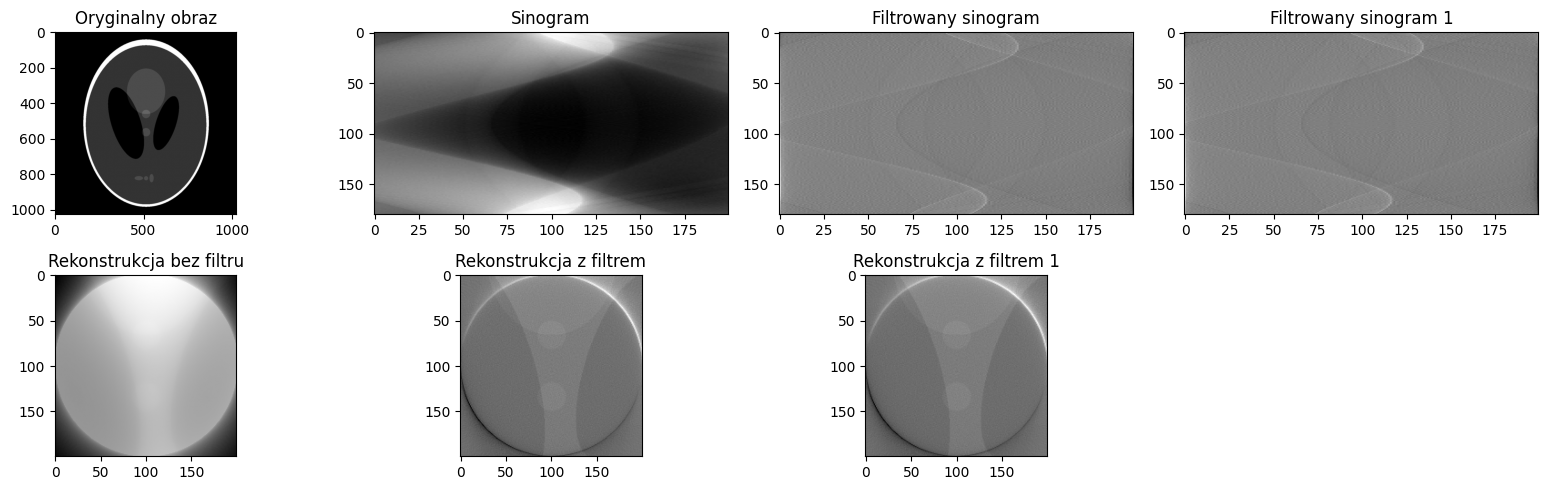

In [31]:
file_path = "tomograf-obrazy/Shepp_logan.jpg"
process_image(file_path, delta_alpha=1.0, n_detectors=200, spread=300)